# 1. Загрузка датасета и внесение случайных искажений #

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.decomposition import PCA
from sklearn.base import clone
from sklearn.tree import DecisionTreeClassifier
import warnings
warnings.filterwarnings('ignore')

### Загрузка датасета ###

In [2]:
# Загрузка датасета
df = pd.read_csv('Train.csv')

print(f"\nРазмер датасета: {df.shape}")
print(f"Количество строк: {df.shape[0]}")
print(f"Количество признаков: {df.shape[1]}")


Размер датасета: (10999, 12)
Количество строк: 10999
Количество признаков: 12


In [3]:
print("\nПервые 5 строк датасета:")
print(df.head())

print("\nИнформация о типах данных:")
print(df.dtypes)

print("\nСтатистическая информация:")
print(df.describe())


Первые 5 строк датасета:
   ID Warehouse_block Mode_of_Shipment  Customer_care_calls  Customer_rating  \
0   1               D           Flight                    4                2   
1   2               F           Flight                    4                5   
2   3               A           Flight                    2                2   
3   4               B           Flight                    3                3   
4   5               C           Flight                    2                2   

   Cost_of_the_Product  Prior_purchases Product_importance Gender  \
0                  177                3                low      F   
1                  216                2                low      M   
2                  183                4                low      M   
3                  176                4             medium      M   
4                  184                3             medium      F   

   Discount_offered  Weight_in_gms  Reached.on.Time_Y.N  
0                44 

### Внесение случайных искажений ###

In [5]:
# Сохраняем копию исходных данных
df_original = df.copy()
np.random.seed(42)

In [6]:
# Добавление пропусков (5% случайных пропусков)
n_missing = int(0.05 * df.shape[0] * df.shape[1])
for _ in range(n_missing):
    row = np.random.randint(0, df.shape[0])
    col = np.random.randint(0, df.shape[1])
    df.iloc[row, col] = np.nan

In [9]:
# Добавление искажений в числовые признаки
numeric_cols = df.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    if col in df.columns and df[col].notna().sum() > 0:
        n_outliers = int(0.02 * len(df))  # 2% искажений
        outlier_indices = np.random.choice(df.index, n_outliers, replace=False)
        mean_val = df[col].mean() # среднее значение
        std_val = df[col].std() # стандартное отклонение
        df.loc[outlier_indices, col] = mean_val + np.random.choice([-1, 1]) * 5 * std_val # среднее +/- 5 × стандартное_отклонение

# 2. Анализ и исправление данных #

### Анализ пропусков ###

In [8]:
# Анализ пропусков
missing_data = df.isnull().sum()
missing_percent = 100 * df.isnull().sum() / len(df)
missing_table = pd.DataFrame({
    'Пропущено значений': missing_data,
    'Процент от общего': missing_percent
})
print(missing_table[missing_table['Пропущено значений'] > 0])

                     Пропущено значений  Процент от общего
ID                                  545           4.954996
Warehouse_block                     522           4.745886
Mode_of_Shipment                    547           4.973179
Customer_care_calls                 503           4.573143
Customer_rating                     502           4.564051
Cost_of_the_Product                 542           4.927721
Prior_purchases                     530           4.818620
Product_importance                  545           4.954996
Gender                              546           4.964088
Discount_offered                    520           4.727703
Weight_in_gms                       519           4.718611
Reached.on.Time_Y.N                 518           4.709519


In [10]:
# Анализ искажений
numeric_cols = df.select_dtypes(include=[np.number]).columns
print(f"Числовые признаки для анализа искажений: {list(numeric_cols)}")

Числовые признаки для анализа искажений: ['ID', 'Customer_care_calls', 'Customer_rating', 'Cost_of_the_Product', 'Prior_purchases', 'Discount_offered', 'Weight_in_gms', 'Reached.on.Time_Y.N']


In [28]:
# 3 копии данных для применения разных стратегий
df_strategy1 = df.copy()
df_strategy2 = df.copy()
df_strategy3 = df.copy()

### Стратегия 1 ###

In [29]:
# СТРАТЕГИЯ 1: Удаление строк с пропусками 
rows_before = len(df_strategy1)
df_strategy1 = df_strategy1.dropna()
rows_removed = rows_before - len(df_strategy1)
print(f"Удалено строк с пропусками: {rows_removed}")
print(f"Размер датасета после очистки: {df_strategy1.shape}")

Удалено строк с пропусками: 4810
Размер датасета после очистки: (6189, 12)


### Стратегия 2 ###

In [30]:
# СТРАТЕГИЯ 2: Заполнение пропусков средним/модой
for col in df_strategy2.columns:
    if df_strategy2[col].isnull().sum() > 0:
        if df_strategy2[col].dtype in ['float64', 'int64']:
            # Для числовых - среднее значение
            mean_value = df_strategy2[col].mean()
            df_strategy2[col].fillna(mean_value, inplace=True)
            print(f"{col}: заполнено средним значением ({mean_value:.2f})")
        else:
            # Для категориальных - мода
            mode_value = df_strategy2[col].mode()[0] if len(df_strategy2[col].mode()) > 0 else 'Unknown'
            df_strategy2[col].fillna(mode_value, inplace=True)
            print(f"{col}: заполнено модой ({mode_value})")

print(f"Размер датасета: {df_strategy2.shape}")

ID: заполнено средним значением (5420.82)
Warehouse_block: заполнено модой (F)
Mode_of_Shipment: заполнено модой (Ship)
Customer_care_calls: заполнено средним значением (4.03)
Customer_rating: заполнено средним значением (2.96)
Cost_of_the_Product: заполнено средним значением (208.98)
Prior_purchases: заполнено средним значением (3.21)
Product_importance: заполнено модой (low)
Gender: заполнено модой (F)
Discount_offered: заполнено средним значением (17.10)
Weight_in_gms: заполнено средним значением (3258.90)
Reached.on.Time_Y.N: заполнено средним значением (0.71)
Размер датасета: (10999, 12)


### Стратегия 3 ###

In [31]:
# СТРАТЕГИЯ 3: Заполнение пропусков медианой/модой + удаление выбросов

# Заполнение пропусков
for col in df_strategy3.columns:
    if df_strategy3[col].isnull().sum() > 0:
        if df_strategy3[col].dtype in ['float64', 'int64']:
            # Для числовых - медиана
            median_value = df_strategy3[col].median()
            df_strategy3[col].fillna(median_value, inplace=True)
            print(f"{col}: заполнено медианой ({median_value:.2f})")
        else:
            # Для категориальных - мода
            mode_value = df_strategy3[col].mode()[0] if len(df_strategy3[col].mode()) > 0 else 'Unknown'
            df_strategy3[col].fillna(mode_value, inplace=True)
            print(f"{col}: заполнено модой ({mode_value})")

# Удаление выбросов по правилу IQR
rows_before = len(df_strategy3)
for col in numeric_cols:
    if col in df_strategy3.columns:
        # Вычисляем квартили
        Q1 = df_strategy3[col].quantile(0.25)
        Q3 = df_strategy3[col].quantile(0.75)
        IQR = Q3 - Q1 # Межквартильный размах
        
        # Определяем границы выбросов
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Удаляем строки с выбросами в этом столбце
        df_strategy3 = df_strategy3[(df_strategy3[col] >= lower_bound) & 
                                     (df_strategy3[col] <= upper_bound)]

outliers_removed = rows_before - len(df_strategy3)
print(f"Удалено выбросов: {outliers_removed} строк")
print(f"Размер датасета после очистки: {df_strategy3.shape}")

ID: заполнено медианой (5488.50)
Warehouse_block: заполнено модой (F)
Mode_of_Shipment: заполнено модой (Ship)
Customer_care_calls: заполнено медианой (4.00)
Customer_rating: заполнено медианой (3.00)
Cost_of_the_Product: заполнено медианой (214.00)
Prior_purchases: заполнено медианой (3.00)
Product_importance: заполнено модой (low)
Gender: заполнено модой (F)
Discount_offered: заполнено медианой (7.00)
Weight_in_gms: заполнено медианой (4076.00)
Reached.on.Time_Y.N: заполнено медианой (1.00)
Удалено выбросов: 4560 строк
Размер датасета после очистки: (6439, 12)


In [33]:
# Выбираем стратегию 3 для дальнейшей работы
df_clean = df_strategy3.copy()

print("Для дальнейшей работы выбрана СТРАТЕГИЯ 3")
print(f"Финальный размер датасета: {df_clean.shape}")

Для дальнейшей работы выбрана СТРАТЕГИЯ 3
Финальный размер датасета: (6439, 12)


# 4. Кодирование категориальных признаков и стандартизация #

In [40]:
# Создаем копию данных для обработки
df_processed = df_clean.copy()

# One-Hot Encoding для категориальных признаков
categorical_cols = df_processed.select_dtypes(include=['object']).columns
print("Категориальные признаки для кодирования:", categorical_cols.tolist())

if len(categorical_cols) > 0:
    # Применяем One-Hot Encoding
    df_encoded = pd.get_dummies(df_processed, columns=categorical_cols, drop_first=True)
    print(f"Размерность после One-Hot Encoding: {df_encoded.shape}")
else:
    df_encoded = df_processed.copy()

# Определяем целевую переменную (последний столбец - целевой)
X = df_encoded.iloc[:, :-1]  # Все кроме последнего столбца
y = df_encoded.iloc[:, -1]   # Последний столбец как целевая переменная

print(f"Признаки: {X.shape}")
print(f"Целевая переменная: {y.shape}")

# Разделяем признаки на те, которые нужно стандартизировать и те, которые не нужно
# Список бинарных столбцов (созданных через one-hot encoding)
binary_cols = [col for col in X.columns if col.startswith(tuple(categorical_cols))]

# Список непрерывных числовых признаков для стандартизации
continuous_cols = [col for col in X.columns if col not in binary_cols and col != 'ID']

# Стандартизация
scaler = StandardScaler()
# Создаем копию X
X_scaled = X.copy()
# Стандартизируем непрерывные признаки
X_scaled[continuous_cols] = scaler.fit_transform(X[continuous_cols])

print("\nДанные после стандартизации:")
print("Непрерывные признаки (стандартизированы):")
print(X_scaled[continuous_cols].describe())

print("\nБинарные признаки (не стандартизированы, оставлены 0/1):")
print(X_scaled[binary_cols].describe())

Категориальные признаки для кодирования: ['Warehouse_block', 'Mode_of_Shipment', 'Product_importance', 'Gender']
Размерность после One-Hot Encoding: (6439, 17)
Признаки: (6439, 16)
Целевая переменная: (6439,)

Данные после стандартизации:
Непрерывные признаки (стандартизированы):
       Customer_care_calls  Customer_rating  Cost_of_the_Product  \
count         6.439000e+03     6.439000e+03         6.439000e+03   
mean         -5.296793e-17    -1.809738e-16         7.062391e-17   
std           1.000078e+00     1.000078e+00         1.000078e+00   
min          -1.852416e+00    -1.440395e+00        -2.490843e+00   
25%          -9.781431e-01    -7.153556e-01        -8.302412e-01   
50%          -1.038700e-01     9.683705e-03         4.263904e-02   
75%           7.704031e-01     7.347230e-01         8.303602e-01   
max           2.518949e+00     1.459762e+00         2.065166e+00   

       Prior_purchases  Discount_offered  Weight_in_gms  Reached.on.Time_Y.N  
count     6.439000e+03     

# 5. Разделение данных и классификация #

Обучающая выборка: (4507, 16)
Тестовая выборка: (1932, 16)
Logistic Regression:
  Обучающая выборка: 0.5274
  Тестовая выборка: 0.5342
  Разница: 0.0068

SVM:
  Обучающая выборка: 0.5250
  Тестовая выборка: 0.5248
  Разница: 0.0001

Random Forest:
  Обучающая выборка: 1.0000
  Тестовая выборка: 0.4917
  Разница: 0.5083



<Figure size 1200x600 with 0 Axes>

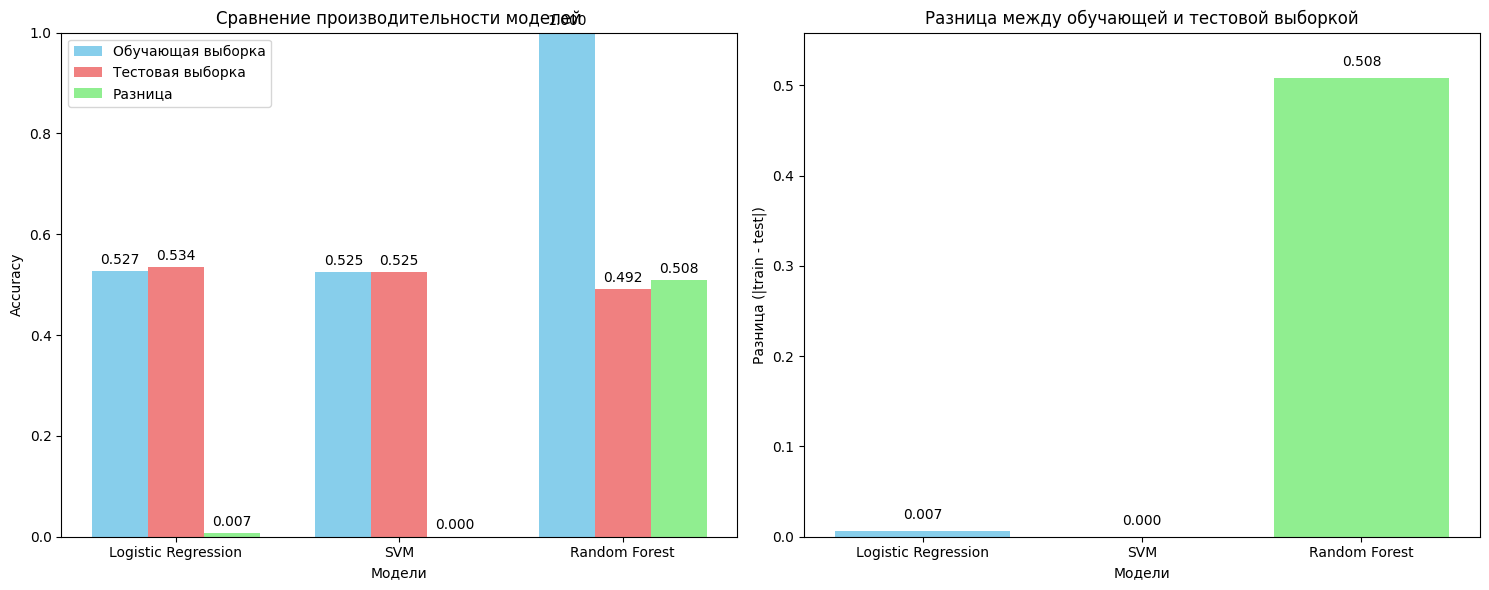


АНАЛИЗ РЕЗУЛЬТАТОВ
Лучшая модель: Logistic Regression с accuracy 0.5342

Признаки переобучения:
- Random Forest: возможное переобучение (разница = 0.5083)


In [42]:
X = X_scaled
y = df_encoded.iloc[:, -1]  # Целевая переменная

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Обучающая выборка: {X_train.shape}")
print(f"Тестовая выборка: {X_test.shape}")

# Модели для сравнения
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'SVM': SVC(random_state=42, probability=True),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100)
}

# Обучение и оценка моделей
results = {}

for name, model in models.items():
    # Обучение
    model.fit(X_train, y_train)
    
    # Предсказания
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Оценка
    train_score = accuracy_score(y_train, y_train_pred)
    test_score = accuracy_score(y_test, y_test_pred)
    
    results[name] = {
        'model': model,
        'train_score': train_score,
        'test_score': test_score,
        'difference': abs(train_score - test_score)
    }
    
    print(f"{name}:")
    print(f"  Обучающая выборка: {train_score:.4f}")
    print(f"  Тестовая выборка: {test_score:.4f}")
    print(f"  Разница: {results[name]['difference']:.4f}")
    print()

# Визуализация сравнения моделей
plt.figure(figsize=(12, 6))

models_names = list(results.keys())
train_scores = [results[name]['train_score'] for name in models_names]
test_scores = [results[name]['test_score'] for name in models_names]
differences = [results[name]['difference'] for name in models_names]

x = np.arange(len(models_names))
width = 0.25

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# График точности
bars1 = ax1.bar(x - width, train_scores, width, label='Обучающая выборка', color='skyblue')
bars2 = ax1.bar(x, test_scores, width, label='Тестовая выборка', color='lightcoral')
bars3 = ax1.bar(x + width, differences, width, label='Разница', color='lightgreen')

ax1.set_xlabel('Модели')
ax1.set_ylabel('Accuracy')
ax1.set_title('Сравнение производительности моделей')
ax1.set_xticks(x)
ax1.set_xticklabels(models_names)
ax1.legend()
ax1.set_ylim(0, 1)

# Добавляем значения на столбцы
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax1.annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

# График разницы между train и test
ax2.bar(models_names, differences, color=['skyblue', 'lightcoral', 'lightgreen'])
ax2.set_xlabel('Модели')
ax2.set_ylabel('Разница (|train - test|)')
ax2.set_title('Разница между обучающей и тестовой выборкой')
ax2.set_ylim(0, max(differences) + 0.05)

for i, v in enumerate(differences):
    ax2.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Анализ результатов
print("\nАНАЛИЗ РЕЗУЛЬТАТОВ")
best_model = max(results.items(), key=lambda x: x[1]['test_score'])
print(f"Лучшая модель: {best_model[0]} с accuracy {best_model[1]['test_score']:.4f}")

print("\nПризнаки переобучения:")
for name, result in results.items():
    if result['difference'] > 0.05:  # Порог для определения переобучения
        print(f"- {name}: возможное переобучение (разница = {result['difference']:.4f})")

# 6. Понижение размерности тремя методами #

In [44]:
# Исходная размернеость, до понижения
print(f"Исходная размерность: {X_train.shape[1]} признаков")

# Метод 1: L1-регуляризация (Lasso)
print("\n1. L1-РЕГУЛЯРИЗАЦИЯ (Lasso)")
l1_model = LogisticRegression(penalty='l1', solver='liblinear', random_state=42, C=0.1)
l1_selector = SelectFromModel(l1_model, threshold='median')
l1_selector.fit(X_train, y_train)

X_train_l1 = l1_selector.transform(X_train)
X_test_l1 = l1_selector.transform(X_test)

selected_features_l1 = X.columns[l1_selector.get_support()]
print(f"Отобрано признаков: {X_train_l1.shape[1]}")
print(f"Отобранные признаки: {list(selected_features_l1)}")

Исходная размерность: 16 признаков

1. L1-РЕГУЛЯРИЗАЦИЯ (Lasso)
Отобрано признаков: 8
Отобранные признаки: ['Customer_care_calls', 'Cost_of_the_Product', 'Prior_purchases', 'Discount_offered', 'Weight_in_gms', 'Reached.on.Time_Y.N', 'Warehouse_block_C', 'Product_importance_medium']


In [45]:
# Метод 2: Последовательный отбор признаков (RFE с Random Forest)
print("\n2. ПОСЛЕДОВАТЕЛЬНЫЙ ОТБОР ПРИЗНАКОВ (RFE)")
rfe_selector = RFE(
    estimator=RandomForestClassifier(random_state=42, n_estimators=50),
    n_features_to_select=8,  # Оставляем 8 наиболее важных признаков
    step=1
)
rfe_selector.fit(X_train, y_train)

X_train_rfe = rfe_selector.transform(X_train)
X_test_rfe = rfe_selector.transform(X_test)

selected_features_rfe = X.columns[rfe_selector.get_support()]
print(f"Отобрано признаков: {X_train_rfe.shape[1]}")
print(f"Отобранные признаки: {list(selected_features_rfe)}")


2. ПОСЛЕДОВАТЕЛЬНЫЙ ОТБОР ПРИЗНАКОВ (RFE)
Отобрано признаков: 8
Отобранные признаки: ['ID', 'Customer_care_calls', 'Customer_rating', 'Cost_of_the_Product', 'Prior_purchases', 'Discount_offered', 'Weight_in_gms', 'Warehouse_block_F']



3. Decision Tree
Отобрано признаков: 8
Отобранные признаки: ['ID', 'Customer_care_calls', 'Customer_rating', 'Cost_of_the_Product', 'Prior_purchases', 'Discount_offered', 'Weight_in_gms', 'Mode_of_Shipment_Ship']


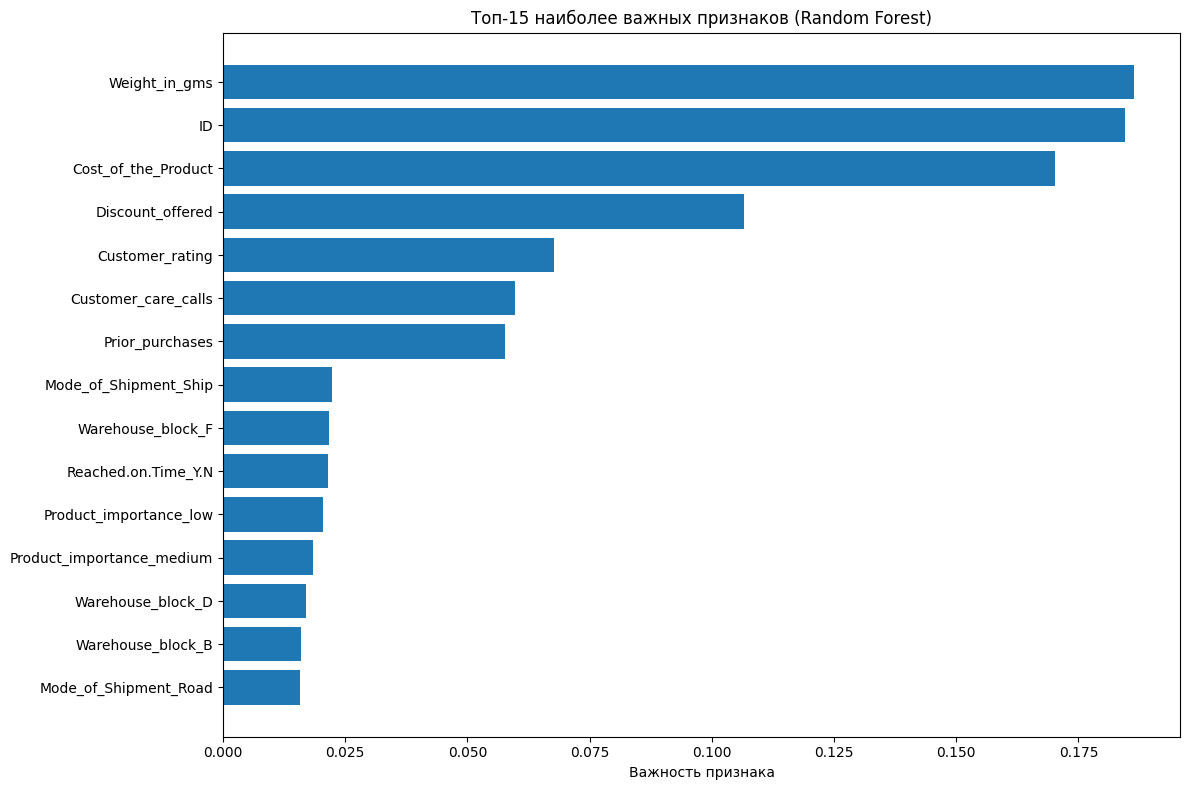


Топ-10 наиболее важных признаков:
                  feature  importance
6           Weight_in_gms    0.186449
0                      ID    0.184582
3     Cost_of_the_Product    0.170232
5        Discount_offered    0.106550
2         Customer_rating    0.067641
1     Customer_care_calls    0.059695
4         Prior_purchases    0.057606
13  Mode_of_Shipment_Ship    0.022270
11      Warehouse_block_F    0.021666
7     Reached.on.Time_Y.N    0.021399


In [48]:
# Метод 3: Важность признаков через дерево решений
print("\n3. Decision Tree")
dt_model = RandomForestClassifier(random_state=42, n_estimators=100)
dt_model.fit(X_train, y_train)

# Выбираем признаки с важностью выше медианы
importances = dt_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': importances
}).sort_values('importance', ascending=False)

threshold = np.median(importances[importances > 0])
dt_selector = SelectFromModel(dt_model, threshold=threshold)
dt_selector.fit(X_train, y_train)

X_train_dt = dt_selector.transform(X_train)
X_test_dt = dt_selector.transform(X_test)

selected_features_dt = X.columns[dt_selector.get_support()]
print(f"Отобрано признаков: {X_train_dt.shape[1]}")
print(f"Отобранные признаки: {list(selected_features_dt)}")

# Визуализация важности признаков
plt.figure(figsize=(12, 8))
top_features = feature_importance_df.head(15)
plt.barh(top_features['feature'], top_features['importance'])
plt.xlabel('Важность признака')
plt.title('Топ-15 наиболее важных признаков (Random Forest)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nТоп-10 наиболее важных признаков:")
print(feature_importance_df.head(10))

### Сравнение методов понижения размерности ###

СРАВНЕНИЕ МЕТОДОВ ПОНИЖЕНИЯ РАЗМЕРНОСТИ

L1 Регуляризация:
  Признаков: 8 (50.0% сокращение)
  Accuracy: 0.5280 (изменение: -0.0062)
  Лучшие признаки: ['Customer_care_calls', 'Cost_of_the_Product', 'Prior_purchases', 'Discount_offered', 'Weight_in_gms']...

RFE:
  Признаков: 8 (50.0% сокращение)
  Accuracy: 0.5223 (изменение: -0.0119)
  Лучшие признаки: ['ID', 'Customer_care_calls', 'Customer_rating', 'Cost_of_the_Product', 'Prior_purchases']...

Важность признаков:
  Признаков: 8 (50.0% сокращение)
  Accuracy: 0.5233 (изменение: -0.0109)
  Лучшие признаки: ['ID', 'Customer_care_calls', 'Customer_rating', 'Cost_of_the_Product', 'Prior_purchases']...



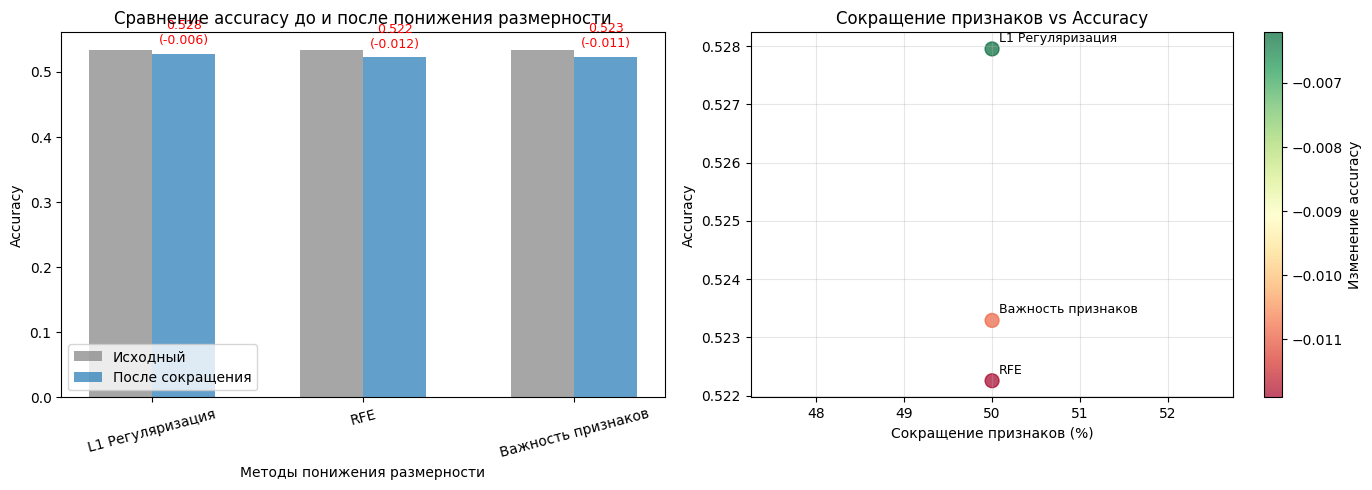

   ЛУЧШИЙ МЕТОД: L1 Регуляризация
   Accuracy: 0.5280
   Сокращение: 50.0%
   Изменение: -0.0062
   Отобранные признаки: ['Customer_care_calls', 'Cost_of_the_Product', 'Prior_purchases', 'Discount_offered', 'Weight_in_gms', 'Reached.on.Time_Y.N', 'Warehouse_block_C', 'Product_importance_medium']


In [52]:
# Сравнение методов понижения размерности
reduction_methods = {
    'L1 Регуляризация': (X_train_l1, X_test_l1, selected_features_l1),
    'RFE': (X_train_rfe, X_test_rfe, selected_features_rfe),
    'Важность признаков': (X_train_dt, X_test_dt, selected_features_dt)
}

reduction_results = {}

print("СРАВНЕНИЕ МЕТОДОВ ПОНИЖЕНИЯ РАЗМЕРНОСТИ\n")

for method_name, (X_train_red, X_test_red, features) in reduction_methods.items():
    # Создаем и обучаем модель на уменьшенных данных
    reduced_model = clone(results[best_model_name]['model'])
    reduced_model.fit(X_train_red, y_train)
    
    # Оценка производительности
    test_score_red = reduced_model.score(X_test_red, y_test)
    original_score = results[best_model_name]['test_score']
    
    reduction_results[method_name] = {
        'test_score': test_score_red,
        'features_count': X_train_red.shape[1],
        'reduction_percent': (1 - X_train_red.shape[1] / X_train.shape[1]) * 100,
        'performance_change': test_score_red - original_score,
        'selected_features': features
    }
    
    print(f"{method_name}:")
    print(f"  Признаков: {X_train_red.shape[1]} ({reduction_results[method_name]['reduction_percent']:.1f}% сокращение)")
    print(f"  Accuracy: {test_score_red:.4f} (изменение: {reduction_results[method_name]['performance_change']:+.4f})")
    print(f"  Лучшие признаки: {list(features)[:5]}{'...' if len(features) > 5 else ''}\n")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# График точности
methods = list(reduction_results.keys())
scores = [reduction_results[m]['test_score'] for m in methods]
reductions = [reduction_results[m]['reduction_percent'] for m in methods]
changes = [reduction_results[m]['performance_change'] for m in methods]

x = np.arange(len(methods))
width = 0.3

# Левый график: Accuracy и изменение
ax1.bar(x - width/2, [results[best_model_name]['test_score']] * len(methods), 
        width, label='Исходный', alpha=0.7, color='gray')
bars = ax1.bar(x + width/2, scores, width, label='После сокращения', alpha=0.7)

ax1.set_xlabel('Методы понижения размерности')
ax1.set_ylabel('Accuracy')
ax1.set_title('Сравнение accuracy до и после понижения размерности')
ax1.set_xticks(x)
ax1.set_xticklabels(methods, rotation=15)
ax1.legend()

# Добавляем значения на столбцы
for i, (bar, change) in enumerate(zip(bars, changes)):
    color = 'green' if change >= 0 else 'red'
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{scores[i]:.3f}\n({change:+.3f})', 
             ha='center', va='bottom', color=color, fontsize=9)

# Правый график
scatter = ax2.scatter(reductions, scores, s=100, c=changes, cmap='RdYlGn', alpha=0.7)
ax2.set_xlabel('Сокращение признаков (%)')
ax2.set_ylabel('Accuracy')
ax2.set_title('Сокращение признаков vs Accuracy')
ax2.grid(True, alpha=0.3)

# Добавляем подписи точек
for i, (method, reduction, score) in enumerate(zip(methods, reductions, scores)):
    ax2.annotate(method, (reduction, score), xytext=(5, 5), textcoords='offset points', fontsize=9)

# Цветовая шкала для изменений
plt.colorbar(scatter, ax=ax2, label='Изменение accuracy')

plt.tight_layout()
plt.show()

# Выбор и вывод лучшего метода
best_reduction = max(reduction_results.items(), key=lambda x: x[1]['test_score'])
print(f"   ЛУЧШИЙ МЕТОД: {best_reduction[0]}")
print(f"   Accuracy: {best_reduction[1]['test_score']:.4f}")
print(f"   Сокращение: {best_reduction[1]['reduction_percent']:.1f}%")
print(f"   Изменение: {best_reduction[1]['performance_change']:+.4f}")
print(f"   Отобранные признаки: {list(best_reduction[1]['selected_features'])}")

# Сохраняем лучший набор для визуализации
X_best_reduced, features_best = reduction_methods[best_reduction[0]][0], best_reduction[1]['selected_features']

# 3. Визуализация после понижения размерности #

ВИЗУАЛИЗАЦИЯ ДАННЫХ
Размерность данных для визуализации: (4507, 9)


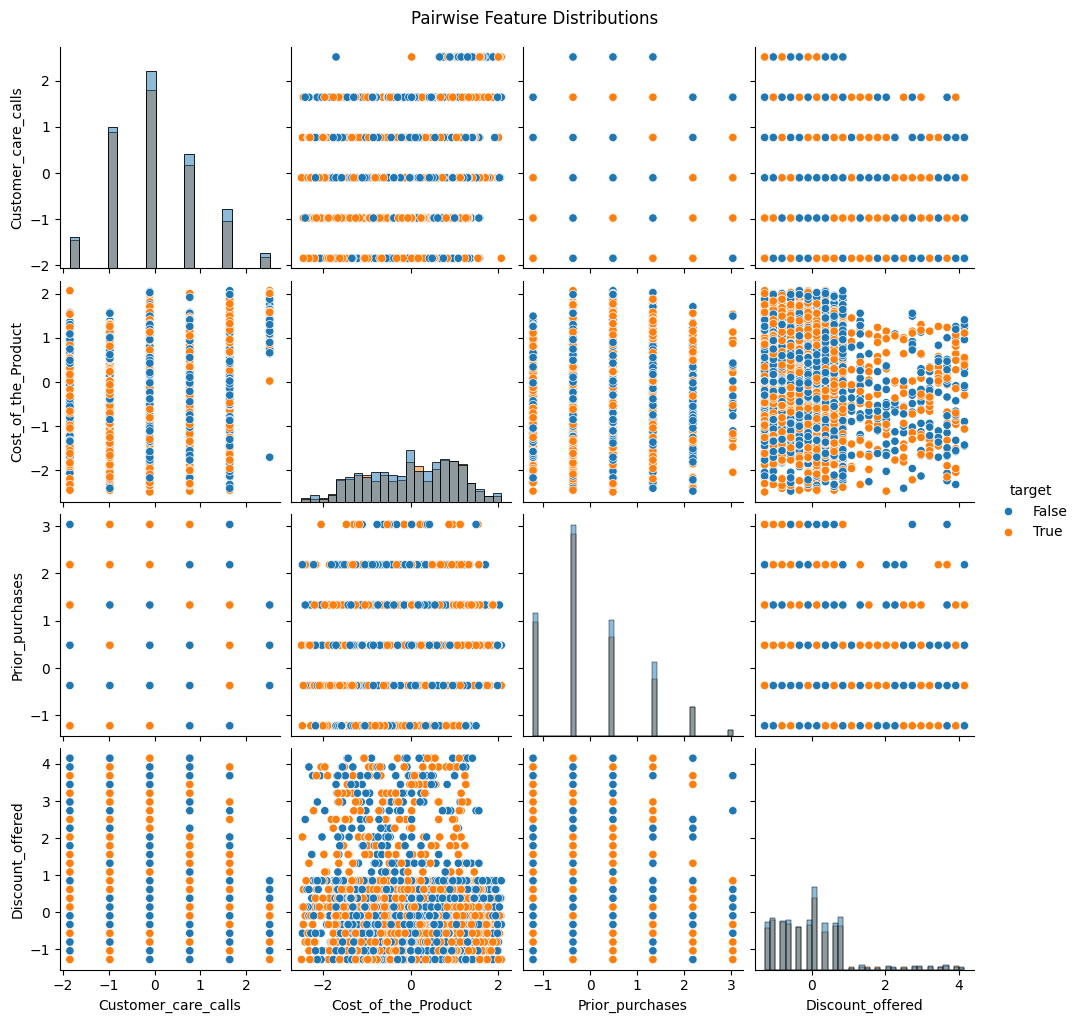

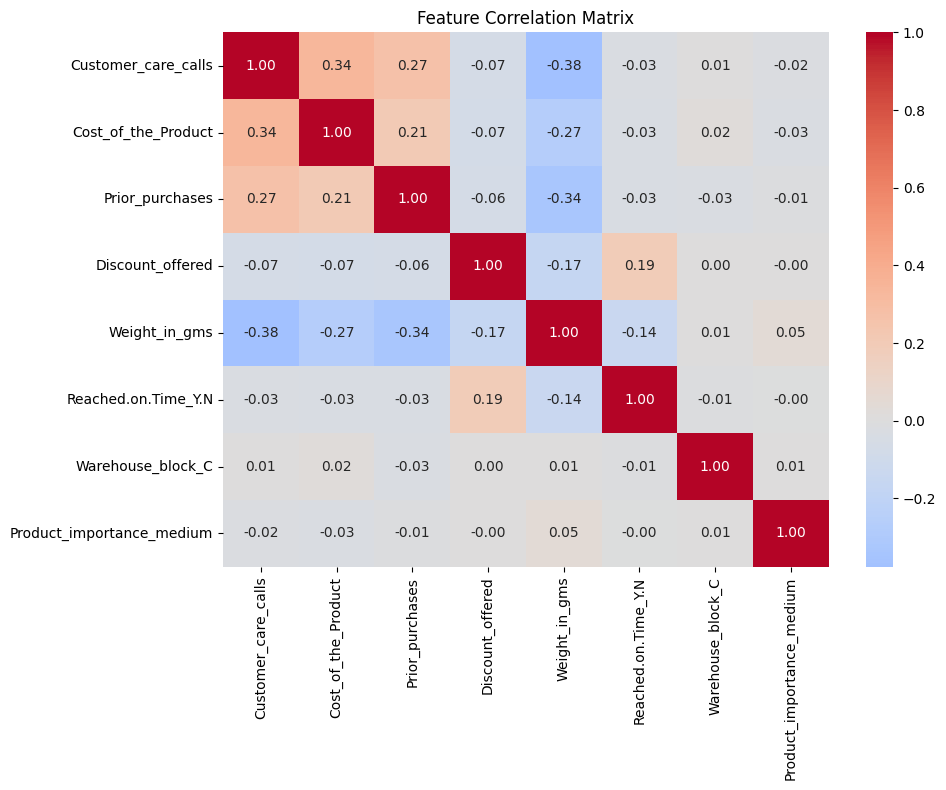

Количество признаков после понижения размерности: 8
Отобранные признаки: ['Customer_care_calls', 'Cost_of_the_Product', 'Prior_purchases', 'Discount_offered', 'Weight_in_gms', 'Reached.on.Time_Y.N', 'Warehouse_block_C', 'Product_importance_medium']

ИТОГОВЫЕ ВЫВОДЫ
1. Лучшая модель: Logistic Regression (accuracy: 0.5342)
2. Лучший метод понижения размерности: L1 Регуляризация
3. Сокращение признаков: 50.0%
4. Accuracy после понижения размерности: 0.5280
5. Понижение размерности НЕ УЛУЧШИЛО производительность модели
6. Ключевые признаки: ['Customer_care_calls', 'Cost_of_the_Product', 'Prior_purchases', 'Discount_offered', 'Weight_in_gms', 'Reached.on.Time_Y.N', 'Warehouse_block_C', 'Product_importance_medium']


In [55]:
print("ВИЗУАЛИЗАЦИЯ ДАННЫХ")

# Создаем DataFrame с отобранными признаками
X_reduced_df = pd.DataFrame(X_best_reduced, columns=features_best)
X_reduced_df['target'] = y_train.values

print(f"Размерность данных для визуализации: {X_reduced_df.shape}")

# Визуализация в зависимости от количества признаков
n_features = len(features_best)

# Матрица scatter plots для нескольких признаков (ограничимся 4)
plot_features = features_best[:4]
plot_df = X_reduced_df[list(plot_features) + ['target']]
    
# Pairplot
sns.pairplot(plot_df, hue='target', diag_kind='hist')
plt.suptitle('Pairwise Feature Distributions', y=1.02)
plt.show()
    
# Heatmap корреляций (показывает зависимости признаков)
# Красный цвет - положительная корреляция (признаки растут вместе)
# Синий цвет - отрицательная корреляция (один признак растет - другой уменьшается)
# Серый - слабая или отсутствующая связь
plt.figure(figsize=(10, 8))
correlation_matrix = X_reduced_df[features_best].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

print(f"Количество признаков после понижения размерности: {n_features}")
print(f"Отобранные признаки: {list(features_best)}")

print("\nИТОГОВЫЕ ВЫВОДЫ")
print(f"1. Лучшая модель: {best_model[0]} (accuracy: {best_model[1]['test_score']:.4f})")
print(f"2. Лучший метод понижения размерности: {best_reduction_method[0]}")
print(f"3. Сокращение признаков: {best_reduction_method[1]['reduction_percent']:.1f}%")
print(f"4. Accuracy после понижения размерности: {best_reduction_method[1]['reduced_test_score']:.4f}")

if best_reduction_method[1]['performance_change'] >= 0:
    print("5. Понижение размерности УЛУЧШИЛО производительность модели")
else:
    print("5. Понижение размерности НЕ УЛУЧШИЛО производительность модели")

print(f"6. Ключевые признаки: {list(features_best)}")